In [1]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas as pd #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling

In [2]:
df = pd.read_csv('t\df_00.csv', index_col=0)

df['tokenized_sents'] = df['AB'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
df['normalized_sents'] = df['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [3]:
dfW2V = gensim.models.word2vec.Word2Vec(df['normalized_sents'].sum())

In [4]:
dfW2V.most_similar('health')

[('determinant', 0.9787886142730713),
 ('social', 0.977689266204834),
 ('public', 0.9691462516784668),
 ('policy', 0.9655609726905823),
 ('need', 0.9550493359565735),
 ('important', 0.9463228583335876),
 ('intervention', 0.9452091455459595),
 ('address', 0.9374183416366577),
 ('promotion', 0.9373345375061035),
 ('research', 0.9350038170814514)]

In [10]:
numWords = 50
targetWords = dfW2V.wv.index2word[:numWords]

wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(dfW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)

In [11]:
pcaWords = sklearn.decomposition.PCA(n_components = 3).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)

tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

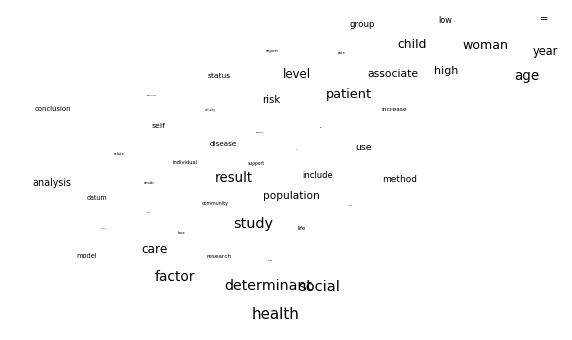

In [12]:
#plot using T-SNE
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0.001)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  15 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

#### Doc2Vec

In [16]:
df['tokenized_words'] = df['AB'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df['normalized_words'] = df['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [17]:
keywords = ['social', 'economic', 'political', 'institution', 'individual', 'behavior', 'family', 'education','health', 'status', 'income', 'sex', 'gender']

In [18]:
taggedDocs = []
for index, row in df.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['PL'])
    docKeywords.append(row['TI']) 
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
df['TaggedAbstracts'] = taggedDocs

In [19]:
dfD2V = gensim.models.doc2vec.Doc2Vec(df['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

C:\Users\Yoojin\Anaconda1\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [20]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = dfD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, dfD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

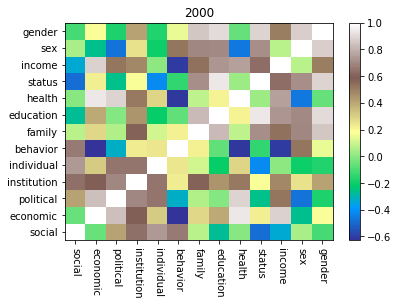

In [24]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

a = ax.set_title('2000')

In [25]:
def makeDF(model, word_list):
    l = []
    r = []
    g = []
    s = []
    for word in word_list:
        l.append(sklearn.metrics.pairwise.cosine_similarity(dfW2V[word].reshape(1,-1), Level.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(dfW2V[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        g.append(sklearn.metrics.pairwise.cosine_similarity(dfW2V[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])


    df = pandas.DataFrame({'level': l, 'race': r, 'gender': g}, index = word_list)
    return df

In [26]:
# functions for getting dimensions

def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [27]:
Level = dimension(dfW2V, ['system','social'], ['behavior', 'behavioral'])
Race = dimension(dfW2V, ['black'], ['white'])
Gender = dimension(dfW2V, ['woman'], ['man'])


# words
diseases = ['cardiovascular', 'respiratory', 'mental']

In [28]:
import pandas 

Disdf = makeDF(dfW2V, diseases) 

In [29]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

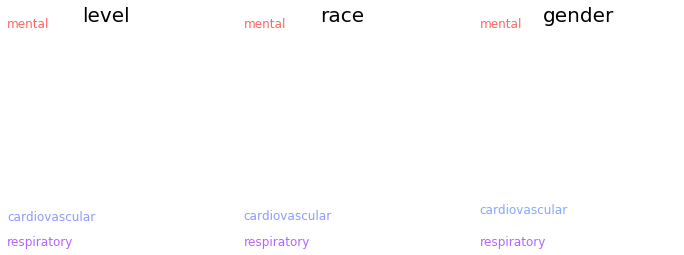

In [30]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Disdf, 'level')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Disdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Disdf, 'gender')
plt.show()